# PoI finding on ASCAD

In [17]:
import re

import h5py
import numpy as np
import seaborn as sns
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
from scipy.stats import beta
from tqdm import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from src.data.loaders.ascad import ASCADData
from src.data.preprocess.hw import hamming_weights
from src.dlla.hw import prepare_traces_dl, dlla_hw
from src.dlla.model9 import make_model_9
from src.tools.cache import cache_np
from src.tools.plotter import init_plots, store_sns
from src.trace_set.transform import fixed_fixed
from src.tvla.cri import tvla_cri

init_plots()

In [2]:
RAW_DATA = ASCADData.raw()
RAW_TRACES = RAW_DATA['traces']

Pre-processed in `./ascad.ipynb`

In [3]:
TARGET_BYTE = 2

STATES_PROF = cache_np("full_states_ascad_profile")[:, 0, 2]
STATES_ATT = cache_np("full_states_ascad_attack")[:, 0, 2]

HW_PROF = hamming_weights(STATES_PROF)
HW_ATT = hamming_weights(STATES_ATT)

In [4]:
SUFFIX = "-ascad"
if TARGET_BYTE == 0:
    SUFFIX += "-none"

In [5]:
PROFILING_MASK = np.ones(len(RAW_TRACES), dtype=bool)
PROFILING_MASK[2::3] = 0
NUM_PROF = np.sum(PROFILING_MASK)

In [6]:
def get_traces(raw_traces: h5py.File, window: (int, int)):
    start, end = window
    window_len = end - start
    num_traces = len(raw_traces)

    acc = np.zeros((num_traces, window_len), dtype=np.int8)
    for ix, trace in tqdm(enumerate(raw_traces), total=num_traces):
        acc[ix] = trace[start:end]

    return acc

WINDOW = (80945 - 15000, 80945 + 15000)

In [7]:
def sub_traces(raw_traces, window, profiling_mask):
    traces = get_traces(raw_traces, window)
    prof_traces = traces[profiling_mask][:-1]
    att_traces = traces[~profiling_mask]

    return np.array((prof_traces, att_traces))

In [8]:
PROF_TRACES, ATT_TRACES = sub_traces(RAW_TRACES, WINDOW, PROFILING_MASK)

100%|██████████| 300001/300001 [07:20<00:00, 681.39it/s]
<ipython-input-7-e93e1858ff3f>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array((prof_traces, att_traces))


In [9]:
A, B = fixed_fixed(PROF_TRACES, HW_PROF)

In [10]:
TVLA = cache_np("window_dlla_t", tvla_cri, A, B, 2, False, True)

In [11]:
def get_corr(traces, labels):
    sample_points = np.transpose(traces)
    num_sample_points = len(sample_points)

    res_01 = np.zeros(num_sample_points, dtype=np.float64)
    for ix in tqdm(range(num_sample_points)):
        res_01[ix] = np.corrcoef(sample_points[ix], labels)[0, 1]

    return np.array(res_01)

CORR = cache_np("window_dlla_corr", get_corr, PROF_TRACES, HW_PROF)

In [12]:
DIST = beta(NUM_PROF/2 - 1, NUM_PROF/2 - 1, loc=-1, scale=2)
CORR_P = 2 * DIST.cdf(-np.abs(CORR))

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
<ipython-input-32-e21d68022fc1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  G.set_xticklabels(list(map(lambda x: int(re.sub(u"\u2212", "-", x.get_text())) + WINDOW[0], G.get_xticklabels())))


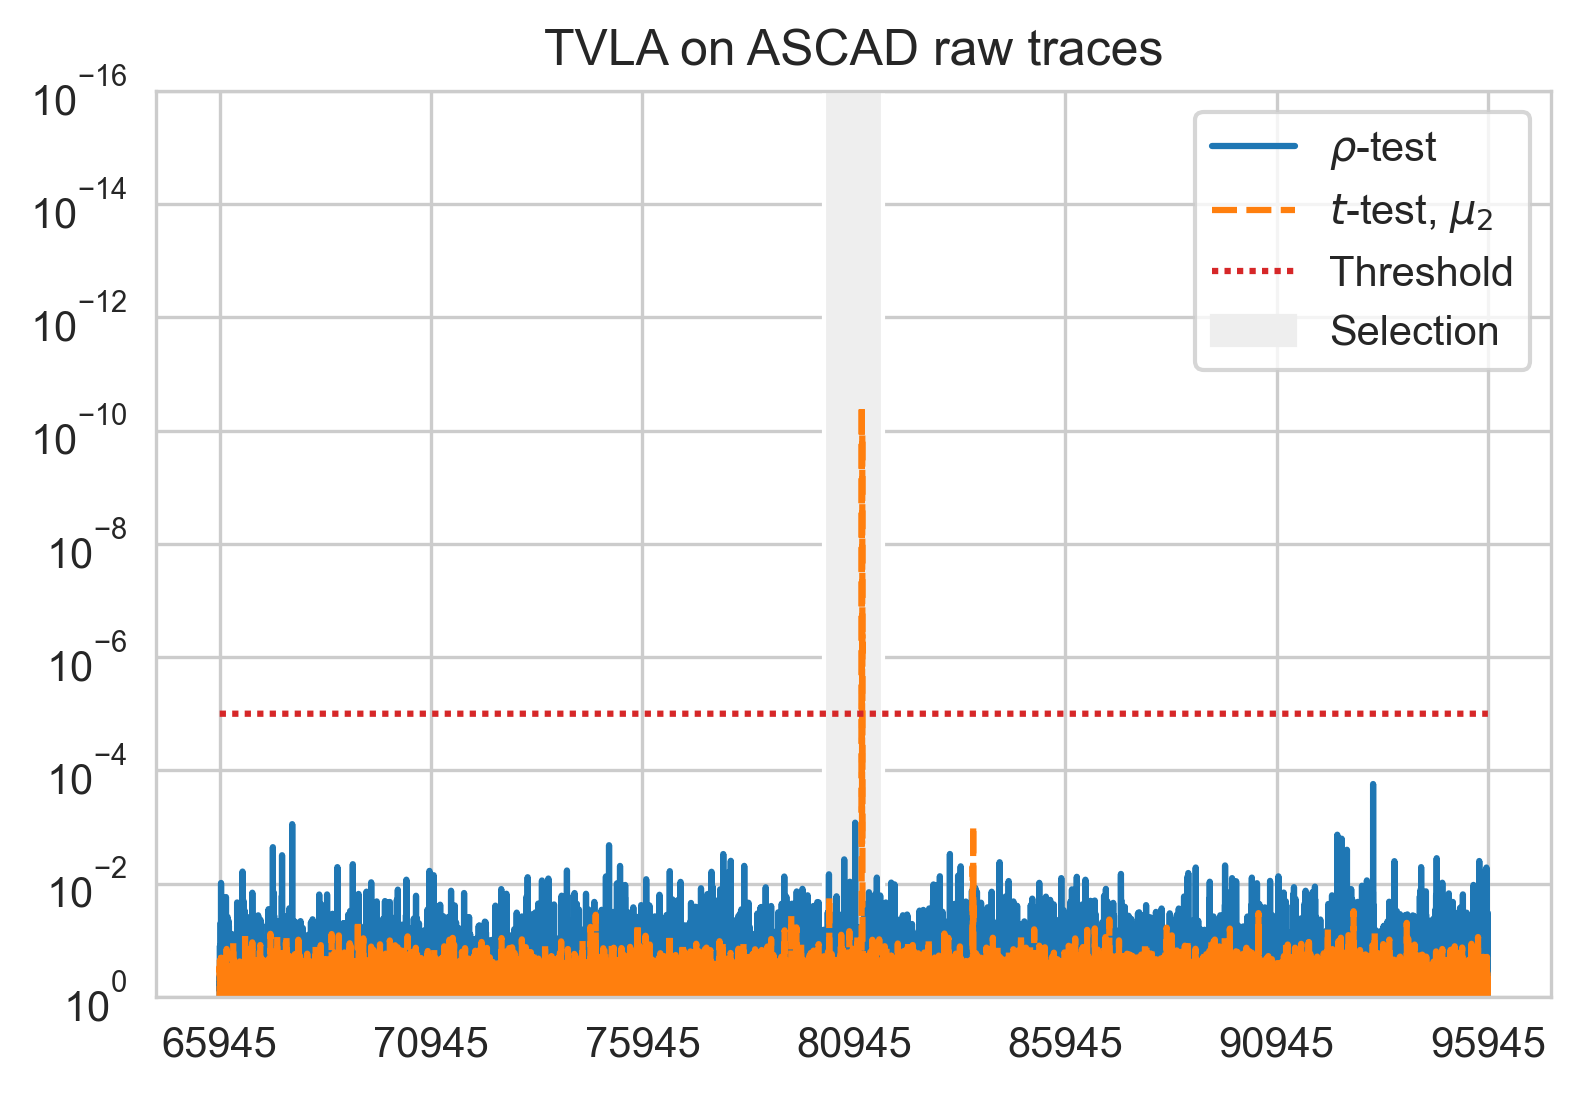

In [32]:
G = sns.lineplot(data={"$\\rho$-test": CORR_P, "$t$-test, $\mu_2$": TVLA[2], "Threshold": [10 ** -5] * TVLA.shape[1]}, palette=np.array(sns.color_palette())[[0, 1, 3]])

plt.axvspan(15000 - 700, 15000 + 700, facecolor='#eee')

handles, labels = G.get_legend_handles_labels()
patch = mpatches.Patch(color='#eee', label='Selection')
handles.append(patch)
plt.legend(handles=handles)

plt.draw()
G.set_xticklabels(list(map(lambda x: int(re.sub(u"\u2212", "-", x.get_text())) + WINDOW[0], G.get_xticklabels())))
G.set(yscale="log", ylim=(1, 10 ** -16), title="TVLA on ASCAD raw traces")

store_sns(G, "p-values-ascad-masked-tvla")

In [14]:
def window_dlla(x, y, x_att, y_att, window_size = 1400):
    num_traces, trace_len = x.shape
    start_ixs = np.arange(0, trace_len + window_size, round(window_size / 2))
    chunks = np.array([(start, start + window_size) for start in start_ixs])

    acc_index = [start + round(window_size / 2) for start, _ in chunks]
    acc = []
    for start, end in tqdm(chunks):
        x9, y9, x9_att, y9_att = prepare_traces_dl(x[:, start:end], y, x_att[:, start:end], y_att)
        mdl9 = make_model_9(x9, y9, x9_att, y9_att)
        p_value = dlla_hw(mdl9,  x9_att, y9_att)
        acc.append(p_value)
        print(start, p_value)

    return np.array((acc_index, acc))

CHUNKS, DLLA_PVS = cache_np("window_dlla", window_dlla, PROF_TRACES, HW_PROF, ATT_TRACES, HW_ATT)

In [15]:
TARGET_IXS = np.arange(max(CHUNKS))

INTER_DLLA_PVS = np.interp(TARGET_IXS, CHUNKS, DLLA_PVS)

<ipython-input-31-28aa1451a0a1>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  G.set_xticklabels(list(map(lambda x: int(re.sub(u"\u2212", "-", x.get_text())) + WINDOW[0], G.get_xticklabels())))


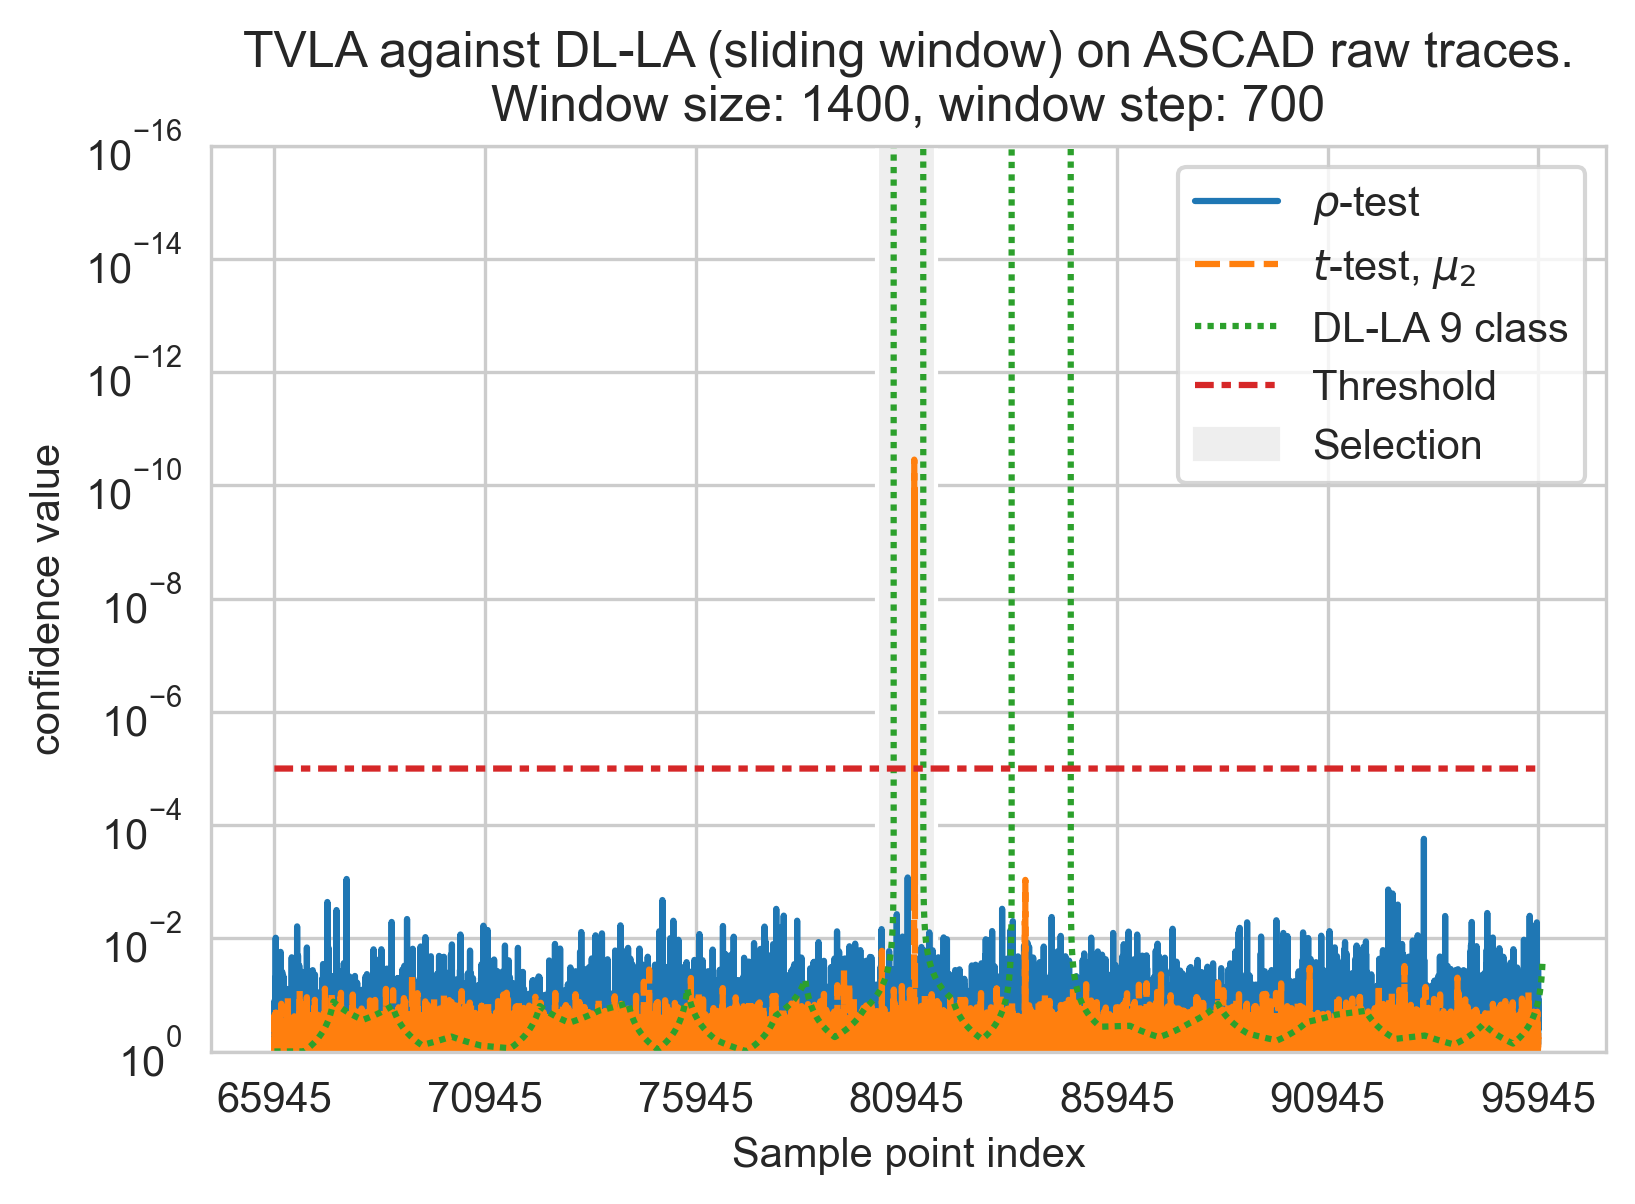

In [31]:
G = sns.lineplot(data={"$\\rho$-test": CORR_P, "$t$-test, $\mu_2$": TVLA[2], "DL-LA 9 class": INTER_DLLA_PVS, "Threshold": [10 ** -5] * TVLA.shape[1]})

G.set(yscale="log", ylim=(1, 10 ** -16),
      title="TVLA against DL-LA (sliding window) on ASCAD raw traces.\nWindow size: 1400, window step: 700",
      xlabel="Sample point index", ylabel="confidence value")

plt.draw()
G.set_xticklabels(list(map(lambda x: int(re.sub(u"\u2212", "-", x.get_text())) + WINDOW[0], G.get_xticklabels())))
plt.axvspan(15000 - 700, 15000 + 700, facecolor='#eee')

handles, labels = G.get_legend_handles_labels()
patch = mpatches.Patch(color='#eee', label='Selection')
handles.append(patch)
plt.legend(handles=handles)

store_sns(G, "p-values-ascad-masked-dlla")